In [1]:
!pip install contractions
!pip install transformers

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import collections
import os
import re
import gdown
import contractions
import unicodedata

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# measure
from sklearn.metrics import recall_score, precision_score, f1_score

## Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import transformers
import tqdm

import nltk
# download nltk data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

import gensim

seed = 42
np.random.seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 42.8 MB/s 
     |████████████████████████████████| 287 kB 65.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 23.5 MB/s 
     |████████████████████████████████| 120 kB 70.7 MB/s 
     |████████████████████████████████| 6.6 MB 65.4 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


## READ DATASET

In [2]:
train_set_git_path = "https://raw.githubusercontent.com/danapr/advanced_ml_anchor/main/dreaddit-train.csv"
test_set_git_path = "https://raw.githubusercontent.com/danapr/advanced_ml_anchor/main/dreaddit-test.csv"

train = pd.read_csv(train_set_git_path)
test = pd.read_csv(test_set_git_path)
train.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


## DATA DESCRIPTION

In [3]:
train.describe()

,id,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
count,2838.000000,2838.000000,2838.000000,2.838000e+03,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,...,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000,2838.000000
mean,13751.999295,0.524313,0.808972,1.518107e+09,18.262156,4.684272,85.996124,35.240941,40.948231,67.044249,...,1.088001,1.120099,1.000211,1.722759,1.536400,1.879385,0.843517,9.948555,5.448836,0.040740
std,17340.161897,0.499497,0.177038,1.552209e+07,79.419166,3.316435,32.334887,26.486189,31.587117,32.880644,...,0.117159,0.085227,0.006500,0.047835,0.102971,0.058932,0.174794,21.798032,2.535829,0.195490
min,4.000000,0.000000,0.428571,1.483274e+09,0.000000,-6.620000,5.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.485400,1.200000,1.561150,0.140000,0.000000,-1.918000,-1.000000
25%,926.250000,0.000000,0.600000,1.509698e+09,2.000000,2.464243,65.000000,12.410000,12.135000,41.070000,...,1.000000,1.000000,1.000000,1.691430,1.469745,1.841782,0.750000,2.000000,3.729973,-0.072222
50%,1891.500000,1.000000,0.800000,1.517066e+09,5.000000,4.321886,81.000000,29.420000,33.520000,80.710000,...,1.000000,1.142900,1.000000,1.721430,1.530295,1.878250,0.890000,5.000000,5.210000,0.044821
75%,25473.750000,1.000000,1.000000,1.530898e+09,10.000000,6.505657,101.000000,55.057500,69.320000,96.180000,...,1.142900,1.142900,1.000000,1.751760,1.596030,1.916243,1.000000,10.000000,6.855217,0.166667
max,55757.000000,1.000000,1.000000,1.542592e+09,1435.000000,24.074231,310.000000,99.000000,99.000000,99.000000,...,1.900000,1.500000,1.200000,2.007400,2.066670,2.158490,1.000000,416.000000,21.198919,1.000000


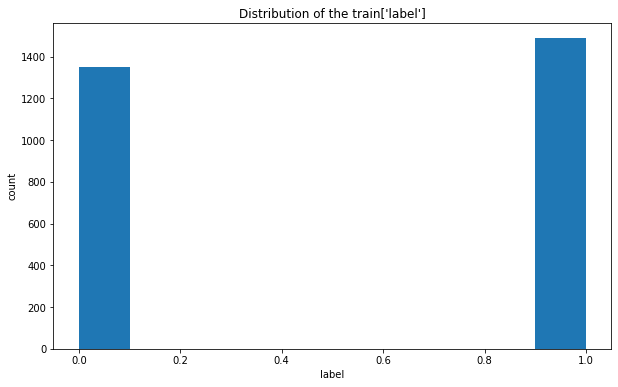

In [4]:
## plot the distribution of the train["label"]
plt.figure(figsize=(10,6))
plt.hist(train["label"], bins=10)
plt.title("Distribution of the train['label']")
plt.xlabel("label")
plt.ylabel("count")
plt.show()

## WORDCLOUD

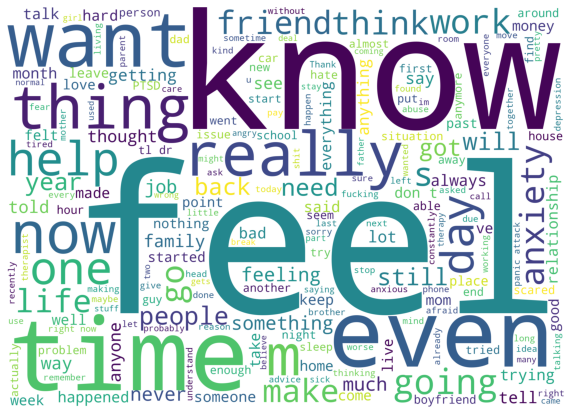

In [5]:
# wordcloud of the top 100 words in the train["text"] where label == 1
train_text = train[train["label"] == 1]["text"]
train_text = train_text.str.cat(sep=" ")
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=2500, height=1800).generate(train_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


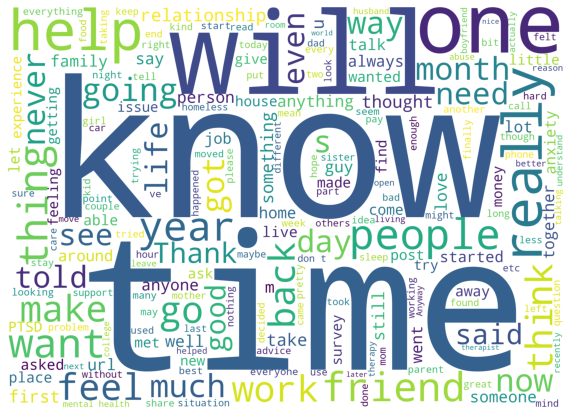

In [6]:
# wordcloud of the top 100 words in the train["text"] where label == 0
train_text = train[train["label"] == 0]["text"]
train_text = train_text.str.cat(sep=" ")
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=2500, height=1800).generate(train_text)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


## CORELATION ANALYSIS WITH RESPECT TO TARGET COLOUMN

In [7]:
target = "label"

In [8]:
# numeric coloumns
numeric_cols = [x for x in train.columns if train[x].dtype in ["int64", "float64"]]
numeric_cols.remove(target)
# categorical columns
categorical_cols = [x for x in train.columns if train[x].dtype == "object"]

In [9]:
# corelation matrix between the "label" and other features
df_corr = pd.DataFrame(columns=["corr", "var1", "target"])
for var in numeric_cols:
    if var != target:
        corr = train[var].corr(train[target])
        df_corr = df_corr.append({"corr": corr, "var1": var, "target": target}, ignore_index=True)
df_corr.sort_values(by="corr", ascending=False)


,corr,var1,target
16,0.400440,lex_liwc_i,label
36,0.387979,lex_liwc_negemo,label
8,0.275282,lex_liwc_Authentic,label
37,0.260146,lex_liwc_anx,label
12,0.241536,lex_liwc_Dic,label
...,...,...,...
35,-0.270672,lex_liwc_posemo,label
101,-0.297439,lex_dal_min_pleasantness,label
110,-0.305157,sentiment,label
7,-0.403804,lex_liwc_Clout,label


In [10]:
# top ten correlated features with the "label"
top_10 = df_corr.sort_values(by="corr", ascending=False).head(10)
top_10["var1"]

16            lex_liwc_i
36       lex_liwc_negemo
8     lex_liwc_Authentic
37          lex_liwc_anx
12          lex_liwc_Dic
13     lex_liwc_function
38        lex_liwc_anger
55         lex_liwc_feel
39          lex_liwc_sad
95      lex_liwc_Apostro
Name: var1, dtype: object

# DATA PRE PROCESSING

### BASIC PREPROCESSING

In [11]:
def strip_html_tags(text):
    # use regex to remove all the html tags
    text = re.sub(r'<[^>]*>', '', text)
    return text

def remove_accented_chars(text):
    # use regex to remove all the accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

# pre-process the train["text"]
train_reviews = train['text'].values
# pre-process the test["text"]
test_reviews = test['text'].values
# normalize the train["text"]
train_reviews_norm = pre_process_corpus(train_reviews)
# normalize the test["text"]
test_reviews_norm = pre_process_corpus(test_reviews)

# replace the train["text"] with the normalized train["text"]
train['text'] = train_reviews_norm
# replace the test["text"] with the normalized test["text"]
test['text'] = test_reviews_norm

# print sample of the normalized train["text"]
train['text'].head()

100%|██████████| 715/715 [00:00<00:00, 5681.57it/s]


0    he said he had not felt that way before sugget...
1    hey there rassistance not sure if this is the ...
2    my mom then hit me with the newspaper and it s...
3    until i met my new boyfriend he is amazing he ...
4    october is domestic violence awareness month a...
Name: text, dtype: object

### LABEL ENCODE subreddit_new

In [12]:
le = LabelEncoder()
col_to_encode = "subreddit"
train[col_to_encode] = le.fit_transform(train[col_to_encode])
test[col_to_encode] = le.transform(test[col_to_encode])


In [13]:
train.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,6,8601tu,"(15, 20)",he said he had not felt that way before sugget...,33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,2,8lbrx9,"(0, 5)",hey there rassistance not sure if this is the ...,2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,6,9ch1zh,"(15, 20)",my mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,7,7rorpp,"[5, 10]",until i met my new boyfriend he is amazing he ...,239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,9,9p2gbc,"[0, 5]",october is domestic violence awareness month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [14]:
test.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,7,7nu7as,"[50, 55]",its like that if you want or not me i have no ...,0,0.8,1.514981e+09,22,-1.238793,...,1.0000,1.2000,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,1,680i6d,"(5, 10)",i man the front desk and my title is hr custom...,0,1.0,1.493348e+09,5,7.684583,...,1.4000,1.1250,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909
2,7977,6,8eeu1t,"(5, 10)",we would be saving so much money with this new...,1,1.0,1.524517e+09,10,2.360408,...,1.1429,1.0000,1.0,1.70974,1.52985,1.86108,1.00,8,3.149288,-0.036818
3,1214,6,8d28vu,"[2, 7]",my ex used to shoot back with do you want me t...,1,0.5,1.524018e+09,5,5.997000,...,1.0000,1.3000,1.0,1.72615,1.52000,1.84909,1.00,7,6.606000,-0.066667
4,1965,7,7r1e85,"[23, 28]",i have not said anything to him yet because i ...,0,0.8,1.516200e+09,138,4.649418,...,1.1250,1.1429,1.0,1.75642,1.43582,1.91725,0.84,70,4.801869,0.141667


In [15]:
## combine the train and test data
df = pd.concat([train, test], ignore_index=True) # ignore_index=True to avoid the index conflict
df = df.sample(frac=1).reset_index(drop=True) # shuffle the dataframe
df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,1,7pqmub,"[0, 5]",so i finally got tired of being anxious and de...,960,1,0.571429,1.515699e+09,1,6.895857,...,1.0000,1.0000,1.0,1.71405,1.60773,1.86013,1.00,0,7.184021,-0.092912
1,1,9u626u,"(100, 105)",my best friend died last year of a rare type o...,24110,1,0.600000,1.541358e+09,12,3.863676,...,1.0000,1.0000,1.0,1.71758,1.64333,1.89395,0.94,3,4.290471,0.109722
2,1,9wvcx2,"[3, 8]",and i will get an intense feeling of impending...,1283,1,0.600000,1.542159e+09,12,1.578667,...,1.0000,1.0000,1.0,1.65270,1.27778,1.83533,1.00,6,2.019444,0.006667
3,5,9lgxzm,"[10, 15]",i am employed full time i have money but i am ...,999,0,1.000000,1.538695e+09,28,3.576667,...,1.4000,1.2222,1.0,1.81693,1.57097,1.96921,0.85,27,4.687568,0.250000
4,6,8rdo15,"[0, 5]",so i have had ptsd a few years now coming up o...,241,0,0.600000,1.529091e+09,3,2.824109,...,1.1429,1.0000,1.0,1.67622,1.41667,1.80497,0.72,1,4.406977,0.202500


In [16]:
# remove ['post_id', 'sentence_range']
df.drop(['id','post_id', 'sentence_range'], axis=1, inplace=True)
df.head(3)

,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,1,so i finally got tired of being anxious and de...,1,0.571429,1.515699e+09,1,6.895857,266,72.73,23.75,...,1.0,1.0,1.0,1.71405,1.60773,1.86013,1.00,0,7.184021,-0.092912
1,1,my best friend died last year of a rare type o...,1,0.600000,1.541358e+09,12,3.863676,68,49.75,11.97,...,1.0,1.0,1.0,1.71758,1.64333,1.89395,0.94,3,4.290471,0.109722
2,1,and i will get an intense feeling of impending...,1,0.600000,1.542159e+09,12,1.578667,43,29.83,17.61,...,1.0,1.0,1.0,1.65270,1.27778,1.83533,1.00,6,2.019444,0.006667


In [17]:
## recalculate numeric and categorical columns
numeric_cols = [x for x in df.columns if df[x].dtype in ["int64", "float64"]]
numeric_cols.remove(target) # remove the target column
categorical_cols = [x for x in df.columns if df[x].dtype == "object"]
print("numeric_cols:", numeric_cols)
print("categorical_cols:", categorical_cols)

numeric_cols: ['subreddit', 'confidence', 'social_timestamp', 'social_karma', 'syntax_ari', 'lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tentat', 'lex_liwc_certain', 'lex_liwc_differ', 'lex_liwc_percept', 'lex_liwc_see', 'lex_liwc_he

In [18]:
# lexical features, features starting with "lex_"
lex_cols = [x for x in df.columns if x.startswith("lex_")]
# add "sentiment" column
lex_cols.append("sentiment")
# symtax features, features starting with "syntax_"
syntax_cols = [x for x in df.columns if x.startswith("syntax_")]
# social features, features starting with "social_"
social_cols = [x for x in df.columns if x.startswith("social_")]
# text cols
text_cols = ["text"]

print("Lexical features:", lex_cols)
print("Syntax features:", syntax_cols)
print("Social features:", social_cols)
print("Text features:", text_cols)

Lexical features: ['lex_liwc_WC', 'lex_liwc_Analytic', 'lex_liwc_Clout', 'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_WPS', 'lex_liwc_Sixltr', 'lex_liwc_Dic', 'lex_liwc_function', 'lex_liwc_pronoun', 'lex_liwc_ppron', 'lex_liwc_i', 'lex_liwc_we', 'lex_liwc_you', 'lex_liwc_shehe', 'lex_liwc_they', 'lex_liwc_ipron', 'lex_liwc_article', 'lex_liwc_prep', 'lex_liwc_auxverb', 'lex_liwc_adverb', 'lex_liwc_conj', 'lex_liwc_negate', 'lex_liwc_verb', 'lex_liwc_adj', 'lex_liwc_compare', 'lex_liwc_interrog', 'lex_liwc_number', 'lex_liwc_quant', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo', 'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_sad', 'lex_liwc_social', 'lex_liwc_family', 'lex_liwc_friend', 'lex_liwc_female', 'lex_liwc_male', 'lex_liwc_cogproc', 'lex_liwc_insight', 'lex_liwc_cause', 'lex_liwc_discrep', 'lex_liwc_tentat', 'lex_liwc_certain', 'lex_liwc_differ', 'lex_liwc_percept', 'lex_liwc_see', 'lex_liwc_hear', 'lex_liwc_feel', 'lex_liwc_bio', 'lex_liwc_body', 'lex_liwc_health',

# TOKENIZERS

## BERT

In [19]:
# INIT BERT TOKENIZER USING TRANSFORMERS
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

In [20]:
# bert tokenized df['text']
bert_tokenized_text = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
bert_tokenized_text.head()

0    [101, 2061, 1045, 2633, 2288, 5458, 1997, 2108...
1    [101, 2026, 2190, 2767, 2351, 2197, 2095, 1997...
2    [101, 1998, 1045, 2097, 2131, 2019, 6387, 3110...
3    [101, 1045, 2572, 4846, 2440, 2051, 1045, 2031...
4    [101, 2061, 1045, 2031, 2018, 19637, 2094, 103...
Name: text, dtype: object

In [21]:
# combined dataset with bert tokenized text and numeric columns
df_bert = pd.concat([pd.DataFrame(bert_tokenized_text.tolist()),df], axis=1)
# drop text column
df_bert.drop(['text'], axis=1, inplace=True)
df_bert.head()

,0,1,2,3,4,5,6,7,8,9,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,101,2061,1045,2633.0,2288.0,5458.0,1997.0,2108.0,11480.0,1998.0,...,1.0000,1.0000,1.0,1.71405,1.60773,1.86013,1.00,0,7.184021,-0.092912
1,101,2026,2190,2767.0,2351.0,2197.0,2095.0,1997.0,1037.0,4678.0,...,1.0000,1.0000,1.0,1.71758,1.64333,1.89395,0.94,3,4.290471,0.109722
2,101,1998,1045,2097.0,2131.0,2019.0,6387.0,3110.0,1997.0,17945.0,...,1.0000,1.0000,1.0,1.65270,1.27778,1.83533,1.00,6,2.019444,0.006667
3,101,1045,2572,4846.0,2440.0,2051.0,1045.0,2031.0,2769.0,2021.0,...,1.4000,1.2222,1.0,1.81693,1.57097,1.96921,0.85,27,4.687568,0.250000
4,101,2061,1045,2031.0,2018.0,19637.0,2094.0,1037.0,2261.0,2086.0,...,1.1429,1.0000,1.0,1.67622,1.41667,1.80497,0.72,1,4.406977,0.202500


## WORD2VEC

In [22]:
## tokenize using Word2Vec
tokenize=df['text'].apply(lambda x: x.split())
w2vec_model=gensim.models.Word2Vec(tokenize,min_count = 1, size = 500, window = 5, sg = 1)
w2vec_model.train(tokenize,total_examples= len(df['text']),epochs=20)
w2v_words = list(w2vec_model.wv.vocab)

print("Freq of the top 10 words in the df['text']:")
print(df['text'].apply(lambda x: collections.Counter(x.split())).sum().most_common(10))
print("Freq of the top 10 words in the w2v_words:")
print(collections.Counter(w2v_words).most_common(10))

Freq of the top 10 words in the df['text']:
[('i', 17556), ('to', 10496), ('and', 9881), ('the', 7787), ('a', 6597), ('my', 5612), ('of', 4586), ('not', 4483), ('is', 4326), ('it', 4194)]
Freq of the top 10 words in the w2v_words:
[('so', 1), ('i', 1), ('finally', 1), ('got', 1), ('tired', 1), ('of', 1), ('being', 1), ('anxious', 1), ('and', 1), ('depressed', 1)]


In [23]:
len(tokenize)

3553

In [24]:
import warnings
warnings.filterwarnings("ignore") # ignore the warning messages

vector=[] # list to store the vectors
for i in tqdm.tqdm(range(len(tokenize))):
    sentence_vector = np.zeros(500)
    for word in tokenize[i]:
        if word in w2v_words:
            sentence_vector += w2vec_model[word]
    vector.append(sentence_vector)

print("Shape of the vector:", np.array(vector).shape)

100%|██████████| 3553/3553 [00:09<00:00, 362.19it/s]

Shape of the vector: (3553, 500)


In [25]:
## convert the vector to pandas dataframe
w2v_tokenized_text = pd.DataFrame(vector)
w2v_tokenized_text.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,-13.671003,0.923286,23.074937,-63.167851,2.222619,-20.122769,-3.697328,13.802134,-11.415140,6.660726,...,12.871730,-3.565071,-0.609879,1.197430,45.950541,-3.548732,16.032852,-6.187075,21.382792,-6.740193
1,-3.590031,0.004882,4.905611,-18.912874,-2.119031,-6.612216,0.763049,1.067973,-3.619623,0.031131,...,1.926760,-1.922903,1.490483,-0.665538,7.955772,-2.875238,4.546067,1.917169,6.990180,-3.394543
2,-1.943542,-0.255758,4.866042,-9.500393,-3.216502,-2.837203,0.970445,0.798544,-1.657726,-1.193319,...,-0.044781,1.073864,1.675094,0.796844,5.999206,-1.322791,4.135895,3.112182,6.505657,-5.190626
3,-5.537098,0.317588,6.561296,-18.388451,-1.361655,-3.604344,-0.640171,4.589195,-1.354082,1.708819,...,4.607976,-3.698787,1.247323,0.165574,6.574779,-4.283593,8.707025,1.575085,5.711062,-2.381486
4,-7.651715,-0.567401,7.907592,-22.436215,-2.783437,-7.587752,0.042800,1.347019,-2.346082,1.639950,...,5.415132,-1.547989,-0.414708,1.247541,15.638407,-2.445212,4.002525,2.230147,7.910592,-0.724473


In [26]:
# combine the vector with the df_bert
df_word2vec = pd.concat([w2v_tokenized_text ,df], axis=1)
# drop "text"
df_word2vec.drop(['text'], axis=1, inplace=True)
df_word2vec.head()

,0,1,2,3,4,5,6,7,8,9,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,-13.671003,0.923286,23.074937,-63.167851,2.222619,-20.122769,-3.697328,13.802134,-11.415140,6.660726,...,1.0000,1.0000,1.0,1.71405,1.60773,1.86013,1.00,0,7.184021,-0.092912
1,-3.590031,0.004882,4.905611,-18.912874,-2.119031,-6.612216,0.763049,1.067973,-3.619623,0.031131,...,1.0000,1.0000,1.0,1.71758,1.64333,1.89395,0.94,3,4.290471,0.109722
2,-1.943542,-0.255758,4.866042,-9.500393,-3.216502,-2.837203,0.970445,0.798544,-1.657726,-1.193319,...,1.0000,1.0000,1.0,1.65270,1.27778,1.83533,1.00,6,2.019444,0.006667
3,-5.537098,0.317588,6.561296,-18.388451,-1.361655,-3.604344,-0.640171,4.589195,-1.354082,1.708819,...,1.4000,1.2222,1.0,1.81693,1.57097,1.96921,0.85,27,4.687568,0.250000
4,-7.651715,-0.567401,7.907592,-22.436215,-2.783437,-7.587752,0.042800,1.347019,-2.346082,1.639950,...,1.1429,1.0000,1.0,1.67622,1.41667,1.80497,0.72,1,4.406977,0.202500


This code was used to create "w2v_pretrained_tokenized_text.csv":

In [27]:
def creat_w2v_pretrained():
    print("Downloading GoogleNews-vectors-negative300.bin.gz")
    id = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
    output = "GoogleNews-vectors-negative300.bin.gz"
    gdown.download(id=id, output=output, quiet=False)

    # pretrained word2vec model
    w2v_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)
    w2v_words = list(w2v_model.wv.vocab)
    print("Freq of the top 10 words in the w2v_words:")
    print(collections.Counter(w2v_words).most_common(10))

    # convert the text to vector using pretrained word2vec model
    vector=[] # list to store the vectors
    for i in tqdm.tqdm(range(len(tokenize))):
        sentence_vector = np.zeros(300)
        for word in tokenize[i]:
            if word in w2v_words:
                sentence_vector += w2v_model[word]
        vector.append(sentence_vector)

    print("Shape of the vector:", np.array(vector).shape)

    ## convert the vector to pandas dataframe
    w2v_pretrained_tokenized_text = pd.DataFrame(vector)
    print("Shape of the w2v_pretrained_tokenized_text:", w2v_pretrained_tokenized_text.shape)
    print(w2v_pretrained_tokenized_text.head(2))
    # save the w2v_pretrained_tokenized_text to csv
    w2v_pretrained_tokenized_text.to_csv("w2v_pretrained_tokenized_text.csv", index=False)



Since it takes a lot of resources to create it, we upladed it to our Git repository, and will use it:

In [28]:
pretrained_w2v_git_path = "https://raw.githubusercontent.com/danapr/advanced_ml_anchor/main/w2v_pretrained_tokenized_text.csv"
w2v_pretrained_tokenized_text = pd.read_csv(pretrained_w2v_git_path)
print("Shape of the w2v_pretrained_tokenized_text:", w2v_pretrained_tokenized_text.shape)
print(w2v_pretrained_tokenized_text.head(2))

Shape of the w2v_pretrained_tokenized_text: (3553, 300)
          0         1         2         3         4         5         6  \
0  2.520645  2.214386  4.191658  8.944868 -3.083617  0.179535  6.110748   
1  0.932404  2.245253  2.517563  6.545759 -1.092430 -2.135010  2.065483   

          7         8         9  ...       290       291       292       293  \
0 -6.158356  5.043494  4.356812  ... -6.200539  3.112907 -8.114960  0.655582   
1 -4.430176  2.554993  4.528076  ... -5.090698  3.072266 -8.433914  1.948360   

        294       295       296       297       298       299  
0 -4.319607  1.021568  3.450745 -1.195312  2.864578 -2.328033  
1 -2.317017 -0.182186  0.008417 -2.289047  4.914818 -2.891777  

[2 rows x 300 columns]


### KERAS TOKENIZER
We turn each review into a sequence to use as training data for our deep learning model. The review becomes a series of integers once each word is assigned an integer index.

In [29]:
# keras tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>")
tokenizer.fit_on_texts(df['text']) # fit the tokenizer on the text
tokenizer.word_index['<PAD'] = 0 # add padding token to the tokenizer

# sequence
sequences = tokenizer.texts_to_sequences(df['text']) # convert the text to sequence using the tokenizer
# Makking the sequence of equal length of 3000
max_length = max(len(s) for s in sequences)
sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post')
print("Shape of the sequences:", sequences.shape)

# to dataframe
keras_tokenized_text = pd.DataFrame(sequences)
keras_tokenized_text.head()

Shape of the sequences: (3553, 316)


,0,1,2,3,4,5,6,7,8,9,...,306,307,308,309,310,311,312,313,314,315
0,25,2,323,96,370,8,80,316,4,522,...,0,0,0,0,0,0,0,0,0,0
1,7,199,181,795,135,128,8,6,2342,594,...,0,0,0,0,0,0,0,0,0,0
2,4,2,51,46,58,976,155,8,5232,3170,...,0,0,0,0,0,0,0,0,0,0
3,2,16,3171,426,55,2,14,171,19,2,...,0,0,0,0,0,0,0,0,0,0
4,25,2,14,43,186,6,126,85,62,372,...,0,0,0,0,0,0,0,0,0,0


# FEATURE SELECTOR

In [30]:
# features to be used in the model
features = df.drop(['text', 'label'], axis=1)
features.head()

,subreddit,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,lex_liwc_Authentic,lex_liwc_Tone,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,1,0.571429,1.515699e+09,1,6.895857,266,72.73,23.75,91.72,5.61,...,1.0000,1.0000,1.0,1.71405,1.60773,1.86013,1.00,0,7.184021,-0.092912
1,1,0.600000,1.541358e+09,12,3.863676,68,49.75,11.97,99.00,8.31,...,1.0000,1.0000,1.0,1.71758,1.64333,1.89395,0.94,3,4.290471,0.109722
2,1,0.600000,1.542159e+09,12,1.578667,43,29.83,17.61,99.00,3.52,...,1.0000,1.0000,1.0,1.65270,1.27778,1.83533,1.00,6,2.019444,0.006667
3,5,1.000000,1.538695e+09,28,3.576667,73,31.12,13.65,72.89,76.42,...,1.4000,1.2222,1.0,1.81693,1.57097,1.96921,0.85,27,4.687568,0.250000
4,6,0.600000,1.529091e+09,3,2.824109,80,27.79,40.12,95.60,49.00,...,1.1429,1.0000,1.0,1.67622,1.41667,1.80497,0.72,1,4.406977,0.202500


### FROM EXTRA TREES CLASSIFIER

                 Feature Name  Importance
9               lex_liwc_Tone    0.072074
7              lex_liwc_Clout    0.044694
36            lex_liwc_negemo    0.024519
16                 lex_liwc_i    0.024478
101  lex_dal_min_pleasantness    0.018906
8          lex_liwc_Authentic    0.018237
35            lex_liwc_posemo    0.016470
40            lex_liwc_social    0.015476
1                  confidence    0.015178
110                 sentiment    0.014908


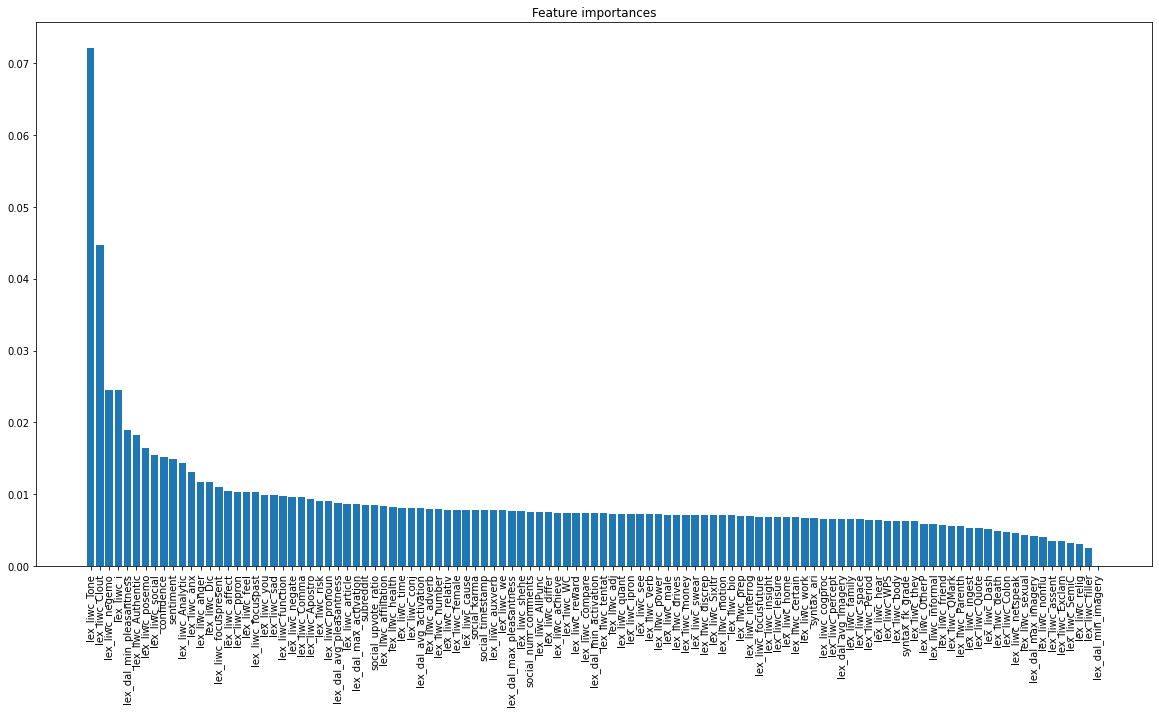

Shape of the selected features: (3553, 27)
Best features based on the feature importances: Index(['confidence', 'lex_liwc_Analytic', 'lex_liwc_Clout',
       'lex_liwc_Authentic', 'lex_liwc_Tone', 'lex_liwc_Dic', 'lex_liwc_ppron',
       'lex_liwc_i', 'lex_liwc_affect', 'lex_liwc_posemo', 'lex_liwc_negemo',
       'lex_liwc_anx', 'lex_liwc_anger', 'lex_liwc_social', 'lex_liwc_feel',
       'lex_liwc_focuspast', 'lex_liwc_focuspresent',
       'lex_dal_min_pleasantness', 'sentiment'],
      dtype='object')


In [31]:
# feature selection based on extra trees classifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

# create the model
model = ExtraTreesClassifier()
# train the model
model.fit(features, df['label'])
# create the selector
selector = SelectFromModel(model, prefit=True)
# select features
selected_features = selector.transform(features)

# df to hold the selected features and importance scores
selected_features_df = pd.DataFrame(columns=['Feature Name', 'Importance'])
# get the feature names and importance scores
for i in range(len(model.feature_importances_)):
    selected_features_df = selected_features_df.append({'Feature Name': features.columns[i], 'Importance': model.feature_importances_[i]}, ignore_index=True)
# sort the dataframe by the importance score
selected_features_df = selected_features_df.sort_values(by='Importance', ascending=False)
# display the top 10 features
print(selected_features_df.head(10))


# plot the feature importances
plt.figure(figsize=(20,10))
plt.title("Feature importances")
# plot from selected_features_df
plt.bar(selected_features_df['Feature Name'], selected_features_df['Importance'])
plt.xticks(rotation=90)
plt.show()

print("Shape of the selected features:", selected_features.shape)
print("Best features based on the feature importances:", features.columns[(model.feature_importances_ > 0.01)])

In [32]:
best_features_extratrees = features.columns[(model.feature_importances_ > 0.01)]

### FROM CORELATION WITH TARGET

In [33]:
# get pearson correlation between the selected features and the target
df_corr = pd.DataFrame(columns=["corr", "var1", "target"])
for var in features.keys():
    if var != target:
        ## peaesons correlation between the selected features and the target
        corr = df[var].corr(df[target])
        df_corr = df_corr.append({'corr': corr, 'var1': var, 'target': target}, ignore_index=True)

# round the correlation values to 2 decimal places
df_corr['corr'] = df_corr['corr'].round(1)
# absolute value of the correlation values
df_corr['absolute_pearson'] = abs(df_corr['corr'])
# sort the dataframe by the absolute value of the correlation values
df_corr = df_corr.sort_values(by='absolute_pearson', ascending=False)
# display
df_corr.head()


,corr,var1,target,absolute_pearson
9,-0.5,lex_liwc_Tone,label,0.5
36,0.4,lex_liwc_negemo,label,0.4
16,0.4,lex_liwc_i,label,0.4
7,-0.4,lex_liwc_Clout,label,0.4
110,-0.3,sentiment,label,0.3


In [34]:
best_features_corr = df_corr.loc[df_corr["absolute_pearson"] >= 0.4, "var1"].tolist()
## add sentiment features to the list of best features
best_features_corr.append("sentiment")
print("Best features based on the pearsons correlation:", best_features_corr)

Best features based on the pearsons correlation: ['lex_liwc_Tone', 'lex_liwc_negemo', 'lex_liwc_i', 'lex_liwc_Clout', 'sentiment']


# CLASSIFIER

In [35]:
res = pd.DataFrame(columns=['Classifier Name', 'Precision', 'Recall', 'F1 Score'] )

### MAJORITY CLASSIFIER

In [36]:
# majority class 
count_zero = np.sum(df['label'] == 0)
count_one = np.sum(df['label'] == 1)
if count_zero > count_one:
    majority_class = 0
else:
    majority_class = 1

print("Majority class:", majority_class)
if majority_class == 0:
    y_pred = np.zeros(len(df))
else:
    y_pred = np.ones(len(df))
actuals = df['label']
count_correct_majority = np.sum(y_pred == actuals)
accuracy_majority = count_correct_majority/len(df)
precision_majority = precision_score(actuals, y_pred)
recall_majority = recall_score(actuals, y_pred)
f1_majority = f1_score(actuals, y_pred)

res = res.append({'Classifier Name': 'Majority Class', 'Precision': precision_majority, 'Recall': recall_majority, 'F1 Score': f1_majority}, ignore_index=True)
# remove duplicate rows
res = res.drop_duplicates()
res

Majority class: 1


,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.0,0.686506


### CNN+features

In [37]:
## HYPERPARAMETERS
EMBED_SIZE = 500 # dimension of the word embedding
EPOCHS=20
BATCH_SIZE=128
VOCAB_SIZE=len(tokenizer.word_index) + 1
INPUT_LENGTH = max_length + len(best_features_corr)

# MODEL
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=INPUT_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='leaky_relu'))
model.add(Dense(1, activation='sigmoid'))

## compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 321, 500)          6763500   
                                                                 
 conv1d (Conv1D)             (None, 321, 128)          256128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 160, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 160, 64)           32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 80, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 80, 32)            8

In [38]:
# combined keras_tokenized_text and selected_features
selected_feature_df = df[best_features_corr]
combined_features = pd.concat([keras_tokenized_text, selected_feature_df], axis=1)
combined_features.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,lex_liwc_Tone,lex_liwc_negemo,lex_liwc_i,lex_liwc_Clout,sentiment
0,25,2,323,96,370,8,80,316,4,522,...,0,0,0,0,0,5.61,2.63,7.52,23.75,-0.092912
1,7,199,181,795,135,128,8,6,2342,594,...,0,0,0,0,0,8.31,2.94,10.29,11.97,0.109722
2,4,2,51,46,58,976,155,8,5232,3170,...,0,0,0,0,0,3.52,2.33,6.98,17.61,0.006667
3,2,16,3171,426,55,2,14,171,19,2,...,0,0,0,0,0,76.42,0.00,10.96,13.65,0.250000
4,25,2,14,43,186,6,126,85,62,372,...,0,0,0,0,0,49.00,3.75,7.50,40.12,0.202500


In [39]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['label'], test_size=0.1, random_state=seed)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3197, 321)
Shape of X_test: (356, 321)
Shape of y_train: (3197,)
Shape of y_test: (356,)


In [40]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/20
23/23 [==============================] - 15s 60ms/step - loss: 0.7018 - accuracy: 0.5405 - val_loss: 0.6321 - val_accuracy: 0.6313
Epoch 2/20
23/23 [==============================] - 1s 37ms/step - loss: 0.4819 - accuracy: 0.7782 - val_loss: 0.5592 - val_accuracy: 0.6875
Epoch 3/20
23/23 [==============================] - 1s 43ms/step - loss: 0.1706 - accuracy: 0.9385 - val_loss: 0.9700 - val_accuracy: 0.6562
Epoch 4/20
23/23 [==============================] - 1s 43ms/step - loss: 0.0333 - accuracy: 0.9920 - val_loss: 1.0209 - val_accuracy: 0.6875
Epoch 5/20
23/23 [==============================] - 1s 44ms/step - loss: 0.0155 - accuracy: 0.9969 - val_loss: 1.2568 - val_accuracy: 0.6906
Epoch 6/20
23/23 [==============================] - 1s 38ms/step - loss: 0.0112 - accuracy: 0.9976 - val_loss: 1.0601 - val_accuracy: 0.7000
Epoch 7/20
23/23 [==============================] - 1s 37ms/step - loss: 0.0126 - accuracy: 0.9983 - val_loss: 0.9577 - val_accuracy: 0.7000
Epoch 8/20
2

In [41]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
## precision , recall, f1 score
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print("Precision: %.2f" % (precision_score(y_test, y_pred)))
print("Recall: %.2f" % (recall_score(y_test, y_pred)))
print("F1 Score: %.2f" % (f1_score(y_test, y_pred)))

res = res.append({'Classifier Name': 'CNN+features*', 'Precision': precision_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred), 'F1 Score': f1_score(y_test, y_pred)}, ignore_index=True)
# remove duplicates
res = res.drop_duplicates()
res


12/12 [==============================] - 0s 12ms/step - loss: 0.9418 - accuracy: 0.6882
Accuracy: 68.82%
Precision: 0.72
Recall: 0.66
F1 Score: 0.69


,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.00000,0.686506
1,CNN+features*,0.719298,0.66129,0.689076


### CNN Only

In [42]:
# CNN on the keras_tokenized_text only

INPUT_LENGTH = max_length
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=INPUT_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='leaky_relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# summarize the model
model.summary()

# Fit the model
model.fit(keras_tokenized_text, df['label'],
          validation_split=0.2,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=1)

# evaluate
scores = model.evaluate(keras_tokenized_text, df['label'], verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
## precision , recall, f1 score
y_pred = model.predict(keras_tokenized_text)
y_pred = (y_pred > 0.5)
print("Precision: %.2f" % (precision_score(df['label'], y_pred)))
print("Recall: %.2f" % (recall_score(df['label'], y_pred)))
print("F1 Score: %.2f" % (f1_score(df['label'], y_pred)))

# append to the results
res = res.append({'Classifier Name': 'CNN*', 'Precision': precision_score(df['label'], y_pred), 'Recall': recall_score(df['label'], y_pred), 'F1 Score': f1_score(df['label'], y_pred)}, ignore_index=True)
# remove duplicates
res = res.drop_duplicates()
res

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 316, 500)          6763500   
                                                                 
 conv1d_3 (Conv1D)           (None, 316, 128)          256128    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 158, 128)         0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 158, 64)           32832     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 79, 64)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 79, 32)           

,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554


### GRNN  + attention

In [43]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

class AttentionLayer(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        # Input shape: 3D tensor with shape: `(samples, steps, features)`.
        # Output shape: 2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """
        
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')

        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)

        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight( shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [44]:
# tf Layer and K
# combined keras_tokenized_text and selected_features
selected_feature_df = df[best_features_corr]
combined_features = pd.concat([keras_tokenized_text, selected_feature_df], axis=1)
combined_features.head()

# train test split
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['label'], test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2842, 321)
Shape of X_test: (711, 321)
Shape of y_train: (2842,)
Shape of y_test: (711,)


In [45]:
# length of features
len_features = X_train.shape[1]

In [46]:
EMBEDDING_DIM = 500 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = tf.keras.layers.Input(shape=(len_features,))
x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp) # embedding layer
x = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x) # GRU
x = AttentionLayer(len_features)(x) # attention layer
x = tf.keras.layers.Dense(GRU_DIM*2, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer
x = tf.keras.layers.Dense(GRU_DIM, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer

outp = tf.keras.layers.Dense(1, activation='sigmoid')(x) # output layer

# model
model = tf.keras.models.Model(inputs=inp, outputs=outp) # initialize the model
# compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
# model summary
model.summary()

# fit the model
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test))

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
## precision , recall, f1 score
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print("Precision: %.2f" % (precision_score(y_test, y_pred)))
print("Recall: %.2f" % (recall_score(y_test, y_pred)))
print("F1 Score: %.2f" % (f1_score(y_test, y_pred)))

res = res.append({'Classifier Name': 'GRNN w/ attention + features*', 'Precision': precision_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred), 'F1 Score': f1_score(y_test, y_pred)}, ignore_index=True)
# remove duplicates
res = res.drop_duplicates()
res


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 321)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 321, 500)          6763500   
                                                                 
 bidirectional (Bidirectiona  (None, 321, 256)         483840    
 l)                                                              
                                                                 
 attention_layer (AttentionL  (None, 256)              577       
 ayer)                                                           
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0     

,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554
3,GRNN w/ attention + features*,0.731771,0.755376,0.743386


## GRNN w/

In [47]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(keras_tokenized_text, df['label'], test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

len_features = X_train.shape[1]

EMBEDDING_DIM = 500 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = tf.keras.layers.Input(shape=(len_features,))
x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp) # embedding layer
x = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x) # GRU
x = AttentionLayer(len_features)(x) # attention layer
x = tf.keras.layers.Dense(GRU_DIM*2, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer
x = tf.keras.layers.Dense(GRU_DIM, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer

outp = tf.keras.layers.Dense(1, activation='sigmoid')(x) # output layer

# model
model = tf.keras.models.Model(inputs=inp, outputs=outp) # initialize the model
# compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
# model summary
model.summary()

# fit the model
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test))

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
## precision , recall, f1 score
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print("Precision: %.2f" % (precision_score(y_test, y_pred)))
print("Recall: %.2f" % (recall_score(y_test, y_pred)))
print("F1 Score: %.2f" % (f1_score(y_test, y_pred)))

res = res.append({'Classifier Name': 'GRNN w/ attention*', 'Precision': precision_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred), 'F1 Score': f1_score(y_test, y_pred)}, ignore_index=True)
# remove duplicates
res = res.drop_duplicates()
res


Shape of X_train: (2842, 316)
Shape of X_test: (711, 316)
Shape of y_train: (2842,)
Shape of y_test: (711,)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 316)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 316, 500)          6763500   
                                                                 
 bidirectional_1 (Bidirectio  (None, 316, 256)         483840    
 nal)                                                            
                                                                 
 attention_layer_1 (Attentio  (None, 256)              572       
 nLayer)                                                         
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                 

,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554
3,GRNN w/ attention + features*,0.731771,0.755376,0.743386
4,GRNN w/ attention*,0.747396,0.771505,0.759259


N-Gram baseline

In [48]:
# n-grams of df["text"]
nltk.download('omw-1.4')

def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

df_copy = df.copy()
# for every item in df["text"], apply basic_clean()
# then get bi-grams of the cleaned text
def get_bigrams(text):
    return list(nltk.bigrams(basic_clean(text)))

# for every item in df["text"], apply basic_clean()
for i in tqdm.tqdm(range(len(df['text']))):
    df_copy['text'][i] = basic_clean(df['text'][i])
    df_copy['text'][i] = get_bigrams(df['text'][i])
    df_copy["text"][i] = list(set(df_copy["text"][i]))
    # join the list of bigrams into a string
    df_copy["text"][i] = ' '.join([x[0]+" "+x[1] for x in df_copy["text"][i]])  


# maximum length of the text
max_len = max([len(x) for x in df_copy['text']])


# keras tokenizer for the text
tokenizer = Tokenizer(num_words=max_len)
tokenizer.fit_on_texts(df_copy['text'])
keras_tokenized_text_ngrams = tokenizer.texts_to_sequences(df_copy['text'])

# to df
keras_tokenized_text_ngrams_df = pd.DataFrame(keras_tokenized_text_ngrams)
# replace NaN with 0
keras_tokenized_text_ngrams_df = keras_tokenized_text_ngrams_df.fillna(0)
keras_tokenized_text_ngrams_df.head()


# train test split
X_train, X_test, y_train, y_test = train_test_split(keras_tokenized_text_ngrams_df, df['label'], test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

len_features = X_train.shape[1]

EMBEDDING_DIM = 500 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = tf.keras.layers.Input(shape=(len_features,))
x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp) # embedding layer
x = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x) # GRU
x = AttentionLayer(len_features)(x) # attention layer
x = tf.keras.layers.Dense(GRU_DIM*2, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer
x = tf.keras.layers.Dense(GRU_DIM, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer

outp = tf.keras.layers.Dense(1, activation='sigmoid')(x) # output layer

# model
model = tf.keras.models.Model(inputs=inp, outputs=outp) # initialize the model
# compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
# model summary
model.summary()

# fit the model
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test))

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
## precision , recall, f1 score
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print("Precision: %.2f" % (precision_score(y_test, y_pred)))
print("Recall: %.2f" % (recall_score(y_test, y_pred)))
print("F1 Score: %.2f" % (f1_score(y_test, y_pred)))
res = res.append({'Classifier Name': 'n-gram baseline*', 'Precision': precision_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred), 'F1 Score': f1_score(y_test, y_pred)}, ignore_index=True)
res

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
100%|██████████| 3553/3553 [00:10<00:00, 337.70it/s]


Shape of X_train: (2842, 216)
Shape of X_test: (711, 216)
Shape of y_train: (2842,)
Shape of y_test: (711,)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 216)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 216, 500)          6763500   
                                                                 
 bidirectional_2 (Bidirectio  (None, 216, 256)         483840    
 nal)                                                            
                                                                 
 attention_layer_2 (Attentio  (None, 256)              472       
 nLayer)                                                         
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                 

,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554
3,GRNN w/ attention + features*,0.731771,0.755376,0.743386
4,GRNN w/ attention*,0.747396,0.771505,0.759259
5,n-gram baseline*,0.700000,0.715054,0.707447


### N-Grams + Features

In [49]:
# n-grams of df["text"]
nltk.download('omw-1.4')

def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

df_copy = df.copy()
# for every item in df["text"], apply basic_clean()
# then get bi-grams of the cleaned text
def get_bigrams(text):
    return list(nltk.bigrams(basic_clean(text)))

# for every item in df["text"], apply basic_clean()
for i in tqdm.tqdm(range(len(df['text']))):
    df_copy['text'][i] = basic_clean(df['text'][i])
    df_copy['text'][i] = get_bigrams(df['text'][i])
    df_copy["text"][i] = list(set(df_copy["text"][i]))
    # join the list of bigrams into a string
    df_copy["text"][i] = ' '.join([x[0]+" "+x[1] for x in df_copy["text"][i]])  


# maximum length of the text
max_len = max([len(x) for x in df_copy['text']])


# keras tokenizer for the text
tokenizer = Tokenizer(num_words=max_len)
tokenizer.fit_on_texts(df_copy['text'])
keras_tokenized_text_ngrams = tokenizer.texts_to_sequences(df_copy['text'])

# to df
keras_tokenized_text_ngrams_df = pd.DataFrame(keras_tokenized_text_ngrams)
# replace NaN with 0
keras_tokenized_text_ngrams_df = keras_tokenized_text_ngrams_df.fillna(0)
keras_tokenized_text_ngrams_df.head()

# concat keras_tokenized_text_ngrams_df and selected_features_corr
selected_feature_df = df[best_features_corr]
keras_tokenized_text_ngrams_df = pd.concat([keras_tokenized_text_ngrams_df, selected_feature_df], axis=1)
# train test split
X_train, X_test, y_train, y_test = train_test_split(keras_tokenized_text_ngrams_df, df['label'], test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

len_features = X_train.shape[1]

EMBEDDING_DIM = 500 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = tf.keras.layers.Input(shape=(len_features,))
x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp) # embedding layer
x = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x) # GRU
x = AttentionLayer(len_features)(x) # attention layer
x = tf.keras.layers.Dense(GRU_DIM*2, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer
x = tf.keras.layers.Dense(GRU_DIM, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer

outp = tf.keras.layers.Dense(1, activation='sigmoid')(x) # output layer

# model
model = tf.keras.models.Model(inputs=inp, outputs=outp) # initialize the model
# compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
# model summary
model.summary()

# fit the model
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test))

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
## precision , recall, f1 score
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print("Precision: %.2f" % (precision_score(y_test, y_pred)))
print("Recall: %.2f" % (recall_score(y_test, y_pred)))
print("F1 Score: %.2f" % (f1_score(y_test, y_pred)))
res = res.append({'Classifier Name': 'n-grams + features*', 'Precision': precision_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred), 'F1 Score': f1_score(y_test, y_pred)}, ignore_index=True)
res

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
100%|██████████| 3553/3553 [00:08<00:00, 412.31it/s]


Shape of X_train: (2842, 221)
Shape of X_test: (711, 221)
Shape of y_train: (2842,)
Shape of y_test: (711,)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 221)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 221, 500)          6763500   
                                                                 
 bidirectional_3 (Bidirectio  (None, 221, 256)         483840    
 nal)                                                            
                                                                 
 attention_layer_3 (Attentio  (None, 256)              477       
 nLayer)                                                         
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                 

,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554
3,GRNN w/ attention + features*,0.731771,0.755376,0.743386
4,GRNN w/ attention*,0.747396,0.771505,0.759259
5,n-gram baseline*,0.700000,0.715054,0.707447
6,n-grams + features*,0.692893,0.733871,0.712794


### LogReg w/ pretrained Word2Vec + features

In [50]:
# w2v_pretrained_tokenized_text
combined_features = pd.concat([w2v_pretrained_tokenized_text, selected_feature_df], axis=1)
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['label'], test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Precision: %.2f" % (precision_score(y_test, y_pred)))
print("Recall: %.2f" % (recall_score(y_test, y_pred)))
print("F1 Score: %.2f" % (f1_score(y_test, y_pred)))
res = res.append({'Classifier Name': 'LogReg w/ pretrained Word2Vec + features', 'Precision': precision_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred), 'F1 Score': f1_score(y_test, y_pred)}, ignore_index=True)
res

Shape of X_train: (2842, 305)
Shape of X_test: (711, 305)
Shape of y_train: (2842,)
Shape of y_test: (711,)
Precision: 0.72
Recall: 0.77
F1 Score: 0.75


,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554
3,GRNN w/ attention + features*,0.731771,0.755376,0.743386
4,GRNN w/ attention*,0.747396,0.771505,0.759259
5,n-gram baseline*,0.700000,0.715054,0.707447
6,n-grams + features*,0.692893,0.733871,0.712794
7,LogReg w/ pretrained Word2Vec + features,0.718204,0.774194,0.745149


### LogReg w/ fine-tuned BERT LM + features*

In [51]:
# w2v_pretrained_tokenized_text
# bert_tokenized_text to df
bert_tokenized_text_df = pd.DataFrame(bert_tokenized_text.tolist())
# replace NaN with 0
bert_tokenized_text_df = bert_tokenized_text_df.fillna(0)
combined_features = pd.concat([bert_tokenized_text_df, selected_feature_df], axis=1)
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['label'], test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Precision: %.2f" % (precision_score(y_test, y_pred)))
print("Recall: %.2f" % (recall_score(y_test, y_pred)))
print("F1 Score: %.2f" % (f1_score(y_test, y_pred)))
res = res.append({'Classifier Name': 'LogReg w/ fine-tuned BERT LM + features*', 'Precision': precision_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred), 'F1 Score': f1_score(y_test, y_pred)}, ignore_index=True)
res

Shape of X_train: (2842, 339)
Shape of X_test: (711, 339)
Shape of y_train: (2842,)
Shape of y_test: (711,)
Precision: 0.67
Recall: 0.70
F1 Score: 0.69


,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554
3,GRNN w/ attention + features*,0.731771,0.755376,0.743386
4,GRNN w/ attention*,0.747396,0.771505,0.759259
5,n-gram baseline*,0.700000,0.715054,0.707447
6,n-grams + features*,0.692893,0.733871,0.712794
7,LogReg w/ pretrained Word2Vec + features,0.718204,0.774194,0.745149
8,LogReg w/ fine-tuned BERT LM + features*,0.670951,0.701613,0.685940


### LogReg w/ domain Word2Vec + features*

In [52]:
# w2v__tokenized_text
combined_features = pd.concat([w2v_tokenized_text, selected_feature_df], axis=1)
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['label'], test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print("Precision: %.2f" % (precision_score(y_test, y_pred)))
print("Recall: %.2f" % (recall_score(y_test, y_pred)))
print("F1 Score: %.2f" % (f1_score(y_test, y_pred)))
res = res.append({'Classifier Name': 'LogReg w/ domain Word2Vec + features*', 'Precision': precision_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred), 'F1 Score': f1_score(y_test, y_pred)}, ignore_index=True)
res

Shape of X_train: (2842, 505)
Shape of X_test: (711, 505)
Shape of y_train: (2842,)
Shape of y_test: (711,)
Precision: 0.77
Recall: 0.79
F1 Score: 0.78


,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554
3,GRNN w/ attention + features*,0.731771,0.755376,0.743386
4,GRNN w/ attention*,0.747396,0.771505,0.759259
5,n-gram baseline*,0.700000,0.715054,0.707447
6,n-grams + features*,0.692893,0.733871,0.712794
7,LogReg w/ pretrained Word2Vec + features,0.718204,0.774194,0.745149
8,LogReg w/ fine-tuned BERT LM + features*,0.670951,0.701613,0.685940
9,LogReg w/ domain Word2Vec + features*,0.769634,0.790323,0.779841


### BERT-base*

In [53]:
# INIT BERT TOKENIZER USING TRANSFORMERS
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# bert tokenized df['text']
bert_base_tokenized_text = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))
# combined dataset with bert tokenized text and numeric columns
df_bert_base = pd.concat([pd.DataFrame(bert_base_tokenized_text.tolist()),df], axis=1)
# drop text column
df_bert_base.drop(['text'], axis=1, inplace=True)
try:
    df_bert_base.drop(['label'], axis=1, inplace=True)
except:
    pass

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_bert_base, df['label'], test_size=0.2, random_state=42)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

# length of features
len_features = X_train.shape[1]

EMBEDDING_DIM = 500 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = tf.keras.layers.Input(shape=(len_features,))
x = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp) # embedding layer
x = tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x) # GRU
x = AttentionLayer(len_features)(x) # attention layer
x = tf.keras.layers.Dense(GRU_DIM*2, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer
x = tf.keras.layers.Dense(GRU_DIM, activation='tanh')(x) # dense layer
x = tf.keras.layers.Dropout(rate=0.2)(x) # dropout layer
outp = tf.keras.layers.Dense(1, activation='sigmoid')(x) # output layer

# model
model = tf.keras.models.Model(inputs=inp, outputs=outp) # initialize the model
# compile the model
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])


# fit the model
model.fit(X_train, y_train, batch_size=128, epochs=20, validation_data=(X_test, y_test))

# evaluate the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))
## precision , recall, f1 score
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
print("Precision: %.2f" % (precision_score(y_test, y_pred)))
print("Recall: %.2f" % (recall_score(y_test, y_pred)))
print("F1 Score: %.2f" % (f1_score(y_test, y_pred)))

res = res.append({'Classifier Name': 'BERT-base*', 'Precision': precision_score(y_test, y_pred), 'Recall': recall_score(y_test, y_pred), 'F1 Score': f1_score(y_test, y_pred)}, ignore_index=True)
# remove duplicates
res = res.drop_duplicates()
res


Shape of X_train: (2842, 445)
Shape of X_test: (711, 445)
Shape of y_train: (2842,)
Shape of y_test: (711,)
Epoch 1/20
23/23 [==============================] - 5s 142ms/step - loss: 0.6934 - accuracy: 0.5106 - val_loss: 0.6936 - val_accuracy: 0.4810
Epoch 2/20
23/23 [==============================] - 3s 118ms/step - loss: 0.6893 - accuracy: 0.5324 - val_loss: 0.6755 - val_accuracy: 0.6203
Epoch 3/20
23/23 [==============================] - 3s 117ms/step - loss: 0.6067 - accuracy: 0.6995 - val_loss: 0.5533 - val_accuracy: 0.7131
Epoch 4/20
23/23 [==============================] - 3s 118ms/step - loss: 0.4726 - accuracy: 0.7745 - val_loss: 0.5090 - val_accuracy: 0.7637
Epoch 5/20
23/23 [==============================] - 3s 119ms/step - loss: 0.3570 - accuracy: 0.8399 - val_loss: 0.5450 - val_accuracy: 0.7511
Epoch 6/20
23/23 [==============================] - 3s 119ms/step - loss: 0.2356 - accuracy: 0.9092 - val_loss: 0.6648 - val_accuracy: 0.7257
Epoch 7/20
23/23 [======================

,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554
3,GRNN w/ attention + features*,0.731771,0.755376,0.743386
4,GRNN w/ attention*,0.747396,0.771505,0.759259
5,n-gram baseline*,0.700000,0.715054,0.707447
6,n-grams + features*,0.692893,0.733871,0.712794
7,LogReg w/ pretrained Word2Vec + features,0.718204,0.774194,0.745149
8,LogReg w/ fine-tuned BERT LM + features*,0.670951,0.701613,0.685940
9,LogReg w/ domain Word2Vec + features*,0.769634,0.790323,0.779841


# FINAL RESULTS

In [54]:
res

,Classifier Name,Precision,Recall,F1 Score
0,Majority Class,0.522657,1.000000,0.686506
1,CNN+features*,0.719298,0.661290,0.689076
2,CNN*,0.963408,0.907377,0.934554
3,GRNN w/ attention + features*,0.731771,0.755376,0.743386
4,GRNN w/ attention*,0.747396,0.771505,0.759259
5,n-gram baseline*,0.700000,0.715054,0.707447
6,n-grams + features*,0.692893,0.733871,0.712794
7,LogReg w/ pretrained Word2Vec + features,0.718204,0.774194,0.745149
8,LogReg w/ fine-tuned BERT LM + features*,0.670951,0.701613,0.685940
9,LogReg w/ domain Word2Vec + features*,0.769634,0.790323,0.779841
